In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac
import torch

from mdps.cattle import cMDPCattle
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPCattle(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,2], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Breeding Stock(x)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [3]:
c = {"context_distribution":
        ConstantDistribution(dim=10, constant_vector=np.array([1.0, 1.4, 0.95, 0.93, 0.7, .53, .40, 1E-8, 3.7, 6.3]))
    }

In [ ]:
'''
np.random.seed(1111)
random.seed(1111)
torch.manual_seed(1111)
'''
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(50):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

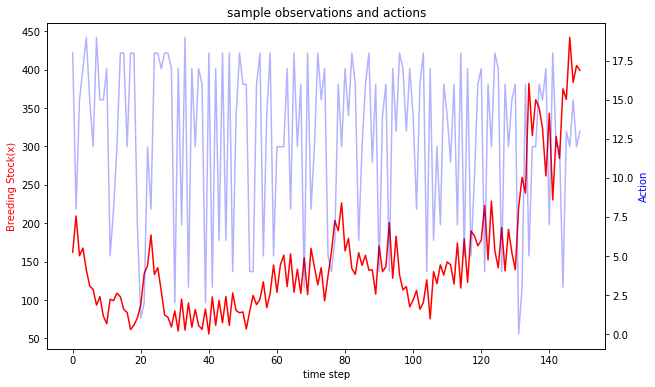

In [118]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)
plot_rollouts(gt_obs_arr, gt_act_arr)

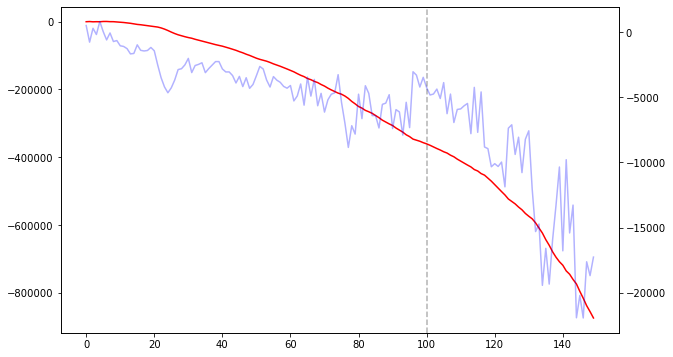

(pid=None) [2022-04-18 10:43:54,245 C 20852 29428] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 2
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


In [119]:
rew = np.zeros(gt_rew_arr.shape[0])
for i in range(rew.shape[0]):
    rew[i] = sum(gt_rew_arr[:i])

fig, ax_1 = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=gt_rew_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, rew, 'r-')
ax_2.plot(x, gt_rew_arr, 'b-', alpha=0.3)
plt.axvline(x=100, alpha=0.3, color='black', linestyle='--')

In [34]:
N = 1000000
T = 100

def posterior_sample_params(action=gt_act_arr, reward=gt_rew_arr, N=N, obs=gt_obs_arr,):
    gamma_0_sample = np.random.normal(loc=1.,scale=1.,size=N)
    rho_h_sample = np.random.normal(loc=1.,scale=1.,size=N)
    sigma_m_sample = np.random.normal(loc=0.5,scale=1.,size=N)
    gamma_1 = 1.4
    g = 0.95
    rho_m = 0.7
    sigma_h = 0.53
    espilon_sq = 1E-8
    mu_h = 3.7
    mu_m = 6.3

    x_pp = obs[:,0]
    x_p = obs[:,1]
    k = obs[:,2]
    m = obs[:,3]
    h = obs[:,4]
    p = obs[:,5]

    c = action.reshape(-1)*k/19
    r = reward.reshape(-1)

    for t in range(T-1):
        # evaluate probability of particles
        h_t = (((p[t] - m[t]) * c[t] - r[t]
                - espilon_sq * (x[t] ** 2 + x_p[t] ** 2 + x_pp[t] ** 2 + c[t] ** 2))
                / (x[t] + gamma_0_sample * g * x_p[t] + gamma_1 * g * x_pp[t]))

        eps_p = p[t+1] - 2.5 - p[t]
        eps_m = m[t+1] - (1 - rho_m) * mu_m - m[t]
        eps_h = h[t+1] - (1 - rho_h_sample) * mu_h - h_t

        likelihood_p = stats.norm.pdf(eps_p, loc=0, scale=4)
        likelihood_m = stats.norm.pdf(eps_m, loc=0, scale=sigma_m_sample)
        likelihood_h = stats.norm.pdf(eps_h, loc=0, scale=sigma_h)
        q = likelihood_p * likelihood_m * likelihood_h
        q = np.nan_to_num(q, copy=False)
        
        if q.sum() == 0.0:
            continue

        # resample particles according to probability
        resample_index = np.random.choice(np.arange(N), N, p=q/q.sum())
        gamma_0_sample = gamma_0_sample[resample_index]
        gamma_0_noise = np.random.normal(loc=0, scale=gamma_0_sample.std(), size=gamma_0_sample.shape) * 0.1
        gamma_0_sample += gamma_0_noise
        rho_h_sample = rho_h_sample[resample_index]
        rho_h_noise = np.random.normal(loc=0, scale=rho_h_sample.std(), size=rho_h_sample.shape) * 0.1
        rho_h_sample += rho_h_noise
        sigma_m_sample = sigma_m_sample[resample_index]
        sigma_m_noise = np.random.normal(loc=0, scale=sigma_m_sample.std(), size=sigma_m_sample.shape) * 0.5
        sigma_m_sample += sigma_m_noise
        
        if t % 25 == 0:
            print("round", t, "posterior mean", sigma_m_sample.mean())

    return gamma_0_sample, rho_h_sample, sigma_m_sample

In [35]:
gamma_0_prior = np.random.normal(loc=1.,scale=1.,size=N)
rho_h_prior = np.random.normal(loc=1.,scale=1.,size=N)
sigma_m_prior = np.random.normal(loc=0.5,scale=1.,size=N)

gamma_0_post, rho_h_post, sigma_m_post = posterior_sample_params()

round 0 posterior mean 0.7133401351362342
round 25 posterior mean 0.3967381913172865
round 50 posterior mean 0.4805694355463338
round 75 posterior mean 0.5512237934067531


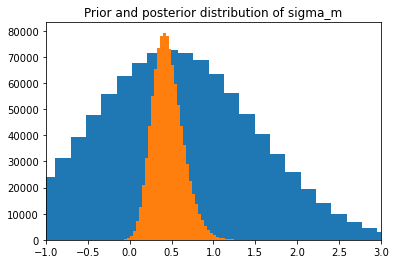

In [36]:
plt.hist(sigma_m_prior, bins=50)
plt.hist(sigma_m_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of sigma_m')
plt.show()

In [38]:
print(gamma_0_post.mean())
print(rho_h_post.mean())
print(sigma_m_post.mean())

4.255591712097042
0.4318155204223993
0.45451983809451596


In [114]:
# Filter function
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,7))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=10,
                                                constant_vector=context_)
            }
            env_ = cMDPCattle(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.3
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 10.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 1].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

In [115]:
# Pre-determined params
N = 1000
T = 100

gamma_0 = np.ones((N,)) * 1.0
# gamma_1 = np.ones((N,)) * 1.4
gamma_1 = np.random.uniform(1.0, 2.0, size=(N,))
g = np.ones((N,)) * 0.95
rho_h = np.ones((N,)) * 0.93
# rho_h = np.random.uniform(0.5, 1.1, size=(N,))
rho_m = np.ones((N,)) * 0.7
# rho_m = np.random.uniform(0.4, 0.8, size=(N,))
sigma_h = np.ones((N,)) * 0.53
# sigma_h = np.random.uniform(0.0, 0.8, size=(N,))
sigma_m = np.ones((N,)) * 0.4
# sigma_m = np.random.uniform(0.0, 0.6, size=(N,))
espilon_sq = np.ones((N,)) * 1E-8
mu_h = np.ones((N,)) * 3.7
mu_m = np.ones((N,)) * 6.3

context_particles = np.abs(np.vstack((gamma_0, gamma_1, g, rho_h, rho_m, sigma_h, sigma_m, espilon_sq, mu_h, mu_m)).T)
context_distribution = ParticleDistribution(dim=10, particles=context_particles, n_particles=N)

In [116]:
c = {"context_distribution":
        ConstantDistribution(dim=10, constant_vector=np.array([1.0, 1.4, 0.95, 0.93, 0.7, .53, .40, 1E-8, 3.7, 6.3]))
    }

In [117]:
context_history_exact, _ = filter_context(expert,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 1.4919708257191395
round 25 posterior mean 1.7904317440968003
round 50 posterior mean 2.1541122001464537
round 75 posterior mean 2.2024827688573825


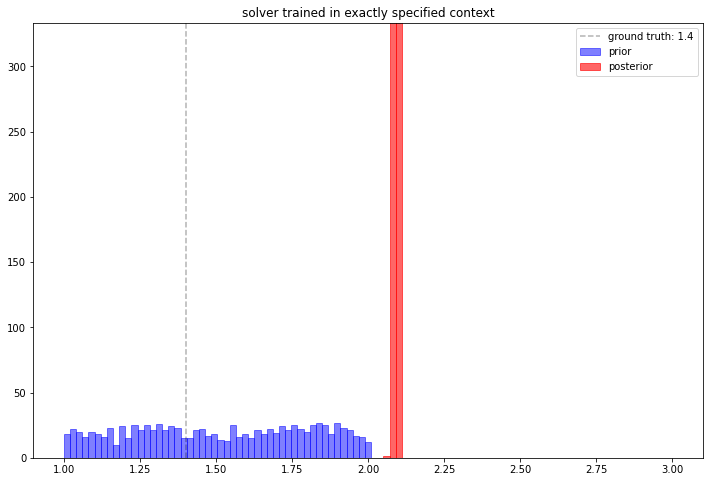

In [113]:
# Plot
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1.0, 3.0, 100)
ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.6)
plt.axvline(x=1.4, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 1.4', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

In [ ]:
'''
p = np.zeros(100)
p[0] = 500
m = np.zeros(100)
m[0] = 350
h = np.zeros(100)
h[0] = 50
for i in range(100-1):
    p[i+1] = p[i] + 25 + np.random.normal(0, 4, 1)[0]
    m[i+1] = m[i] + 0.3*63 + np.random.normal(0, 4, 1)[0]
    h[i+1] = h[i] + 0.07*37 + np.random.normal(0, 5.3, 1)[0]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=100)
ax.plot(x, p, 'r-')
ax.plot(x, m, 'b-', alpha=0.3)
ax.plot(x, h, 'g-')
ax.plot(x, p-m-2.2*h, 'y-')
ax.axhline(y=0.0, alpha=0.3, color='black', linestyle='--')
'''